## 1️⃣ Setup & Dependencies

In [ ]:
!pip install torch transformers scikit-learn imbalanced-learn pandas numpy matplotlib seaborn tqdm joblib -q

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import time
import json

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
RANDOM_SEED = 42

Device: cuda


In [ ]:
# ══════════════════════════════════════════════════════════════
# REPRODUCIBILITY SETUP
# ══════════════════════════════════════════════════════════════
import random
import os

RANDOM_SEED = 42

def set_all_seeds(seed=RANDOM_SEED):
    """Set seeds for complete reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    # Force deterministic algorithms in PyTorch
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"✅ All random seeds set to {seed} for reproducibility")

set_all_seeds()


✅ All random seeds set to 42 for reproducibility


## 2️⃣ Upload Dataset

In [ ]:
from google.colab import files
print("Upload adddosdn.csv:")
uploaded = files.upload()
DATA_FILE = list(uploaded.keys())[0]

Upload adddosdn.csv:


Saving adddosdn_cicflow_dataset.csv to adddosdn_cicflow_dataset.csv


📊 DATASET OVERVIEW
Shape: 268,887 rows × 86 columns
Memory usage: 256.39 MB
Missing values: 0
Inf values: 0
Duplicate rows: 0


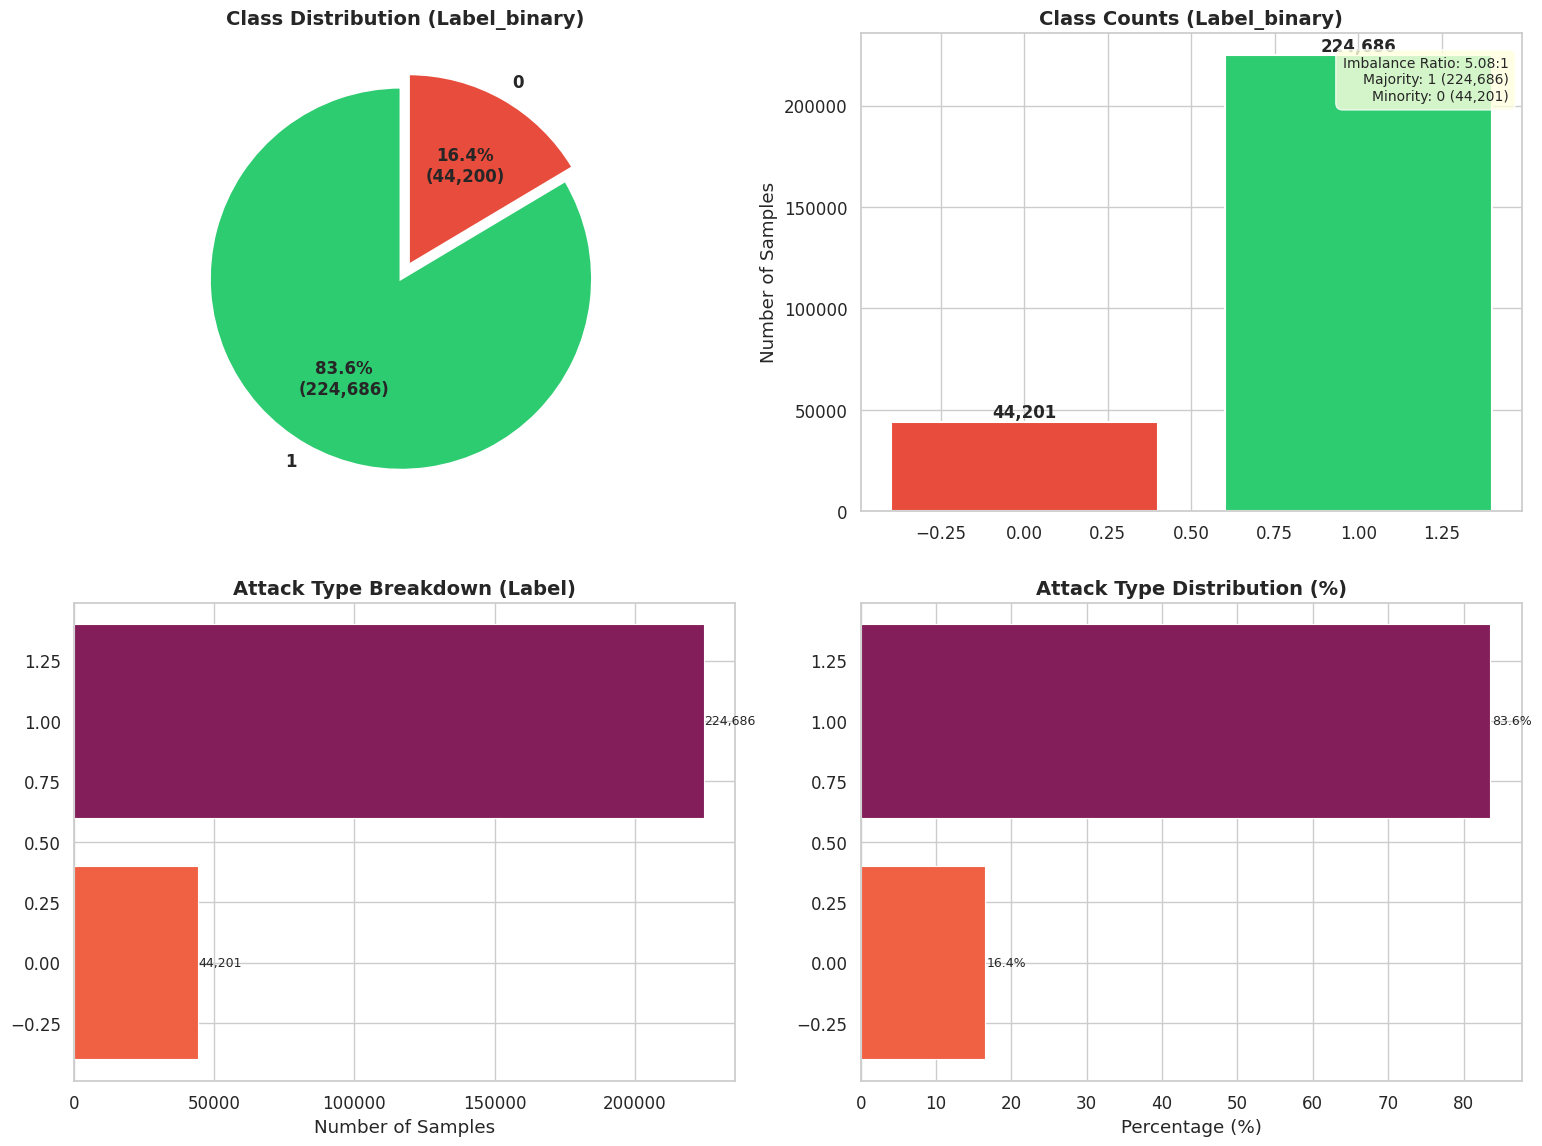


⚖️  IMBALANCE SUMMARY
Majority class: 1 → 224,686 samples (83.6%)
Minority class: 0 → 44,201 samples (16.4%)
Imbalance ratio: 5.08:1
⚠️  Severe imbalance detected → SMOTE recommended


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ── 1. Load & Basic Info ──────────────────────────────────────
df_raw = pd.read_csv(DATA_FILE)
print('=' * 60)
print('📊 DATASET OVERVIEW')
print('=' * 60)
print(f'Shape: {df_raw.shape[0]:,} rows × {df_raw.shape[1]} columns')
print(f'Memory usage: {df_raw.memory_usage(deep=True).sum() / 1e6:.2f} MB')

# Missing & Inf values
n_missing = df_raw.isnull().sum().sum()
numeric_cols = df_raw.select_dtypes(include=[np.number]).columns
n_inf = np.isinf(df_raw[numeric_cols]).sum().sum()
n_dup = df_raw.duplicated().sum()
print(f'Missing values: {n_missing:,}')
print(f'Inf values: {n_inf:,}')
print(f'Duplicate rows: {n_dup:,}')

# Detect label columns
label_col = 'Label_binary'  # Dùng label nhị phân
class_col = 'Attack_Type'   # Dùng attack type cho phân tích chi tiết
col_to_plot = label_col

# ── 2. Plotting ──────────────────────────────────────────────
sns.set_theme(style='whitegrid', font_scale=1.1)
palette_main = ['#2ecc71', '#e74c3c']

has_both = label_col is not None and class_col is not None
n_rows = 2 if has_both else 1

fig, axes = plt.subplots(n_rows, 2, figsize=(16, 6 * n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)

# ── Row 1: Class distribution (Attack vs Benign) ─────────────
class_counts = df_raw[col_to_plot].value_counts()

# Pie chart
axes[0, 0].pie(
    class_counts.values,
    labels=class_counts.index,
    autopct=lambda p: f'{p:.1f}%\n({int(p * sum(class_counts.values) / 100):,})',
    colors=palette_main[:len(class_counts)],
    startangle=90,
    explode=[0.04] * len(class_counts),
    textprops={'fontsize': 12, 'fontweight': 'bold'},
    wedgeprops={'edgecolor': 'white', 'linewidth': 2}
)
axes[0, 0].set_title(f'Class Distribution ({col_to_plot})', fontsize=14, fontweight='bold')

# Bar chart with counts
bars = axes[0, 1].bar(class_counts.index, class_counts.values,
                       color=palette_main[:len(class_counts)],
                       edgecolor='white', linewidth=1.5)
for bar, val in zip(bars, class_counts.values):
    axes[0, 1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 100,
                    f'{val:,}', ha='center', va='bottom', fontweight='bold', fontsize=12)
axes[0, 1].set_title(f'Class Counts ({col_to_plot})', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Number of Samples')

# Imbalance ratio annotation
majority = class_counts.max()
minority = class_counts.min()
ratio = majority / minority
axes[0, 1].text(0.98, 0.95,
    f'Imbalance Ratio: {ratio:.2f}:1\nMajority: {class_counts.idxmax()} ({majority:,})\nMinority: {class_counts.idxmin()} ({minority:,})',
    transform=axes[0, 1].transAxes, fontsize=10,
    verticalalignment='top', horizontalalignment='right',
    bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.8))

# ── Row 2: Attack type breakdown (if Label column exists) ────
if has_both and label_col:
    label_counts = df_raw[label_col].value_counts()
    n_types = len(label_counts)
    colors_atk = sns.color_palette('rocket', n_colors=n_types)

    # Horizontal bar chart
    bars2 = axes[1, 0].barh(label_counts.index[::-1], label_counts.values[::-1],
                             color=colors_atk[::-1], edgecolor='white', linewidth=0.8)
    for bar, val in zip(bars2, label_counts.values[::-1]):
        axes[1, 0].text(bar.get_width() + 50, bar.get_y() + bar.get_height() / 2,
                        f'{val:,}', va='center', fontsize=9)
    axes[1, 0].set_title('Attack Type Breakdown (Label)', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Number of Samples')

    # Percentage breakdown
    label_pct = (label_counts / label_counts.sum() * 100).round(2)
    axes[1, 1].barh(label_pct.index[::-1], label_pct.values[::-1],
                     color=colors_atk[::-1], edgecolor='white', linewidth=0.8)
    for i, (idx, val) in enumerate(zip(label_pct.index[::-1], label_pct.values[::-1])):
        axes[1, 1].text(val + 0.3, i, f'{val:.1f}%', va='center', fontsize=9)
    axes[1, 1].set_title('Attack Type Distribution (%)', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Percentage (%)')

plt.tight_layout(pad=2.0)
plt.show()

# ── 3. Summary Statistics ────────────────────────────────────
print('\n' + '=' * 60)
print('⚖️  IMBALANCE SUMMARY')
print('=' * 60)
print(f'Majority class: {class_counts.idxmax()} → {majority:,} samples ({majority/len(df_raw)*100:.1f}%)')
print(f'Minority class: {class_counts.idxmin()} → {minority:,} samples ({minority/len(df_raw)*100:.1f}%)')
print(f'Imbalance ratio: {ratio:.2f}:1')
if ratio > 3:
    print('⚠️  Severe imbalance detected → SMOTE recommended')
elif ratio > 1.5:
    print('⚡ Moderate imbalance → Consider oversampling/weights')
else:
    print('✅ Balanced dataset')

if label_col and label_col != col_to_plot:
    print(f'\n🏷️  Attack types found: {df_raw[label_col].nunique()}')
    for lbl, cnt in df_raw[label_col].value_counts().items():
        print(f'  • {lbl}: {cnt:,} ({cnt/len(df_raw)*100:.1f}%)')

del df_raw  # Free memory

## 3️⃣ Data Processing

**Pipeline:** `Clean → Encode → SPLIT FIRST → Scale(Train) → SMOTE(Train)`

In [ ]:
# STEP 1: Load & Clean
print("="*60)
print("STEP 1: DATA CLEANING")
print("="*60)

df = pd.read_csv(DATA_FILE)
print(f"Original: {len(df)} rows")

if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

df = df.dropna()
df = df.replace([np.inf, -np.inf], np.nan).dropna()
df = df.drop_duplicates()
print(f"Cleaned: {len(df)} rows")

STEP 1: DATA CLEANING
Original: 268887 rows
Cleaned: 268887 rows


In [ ]:
# STEP 2: LABEL ENCODING
print("\nSTEP 2: LABEL ENCODING")

# AdDDoSDN có 3 cột label: Label_multi, Label_binary, Attack_Type
# Chọn Label_binary cho bài toán phân loại nhị phân
label_col = 'Label_binary'  # 0=normal, 1=attack

le = LabelEncoder()
df['encoded_label'] = df[label_col]  # Đã là 0/1 rồi, không cần encode
print(f"Classes: {df[label_col].value_counts().to_dict()}")
print(f"Distribution: {df['encoded_label'].value_counts().to_dict()}")


STEP 2: LABEL ENCODING
Classes: {1: 224686, 0: 44201}
Distribution: {1: 224686, 0: 44201}


In [ ]:
# STEP 3: SPLIT FIRST (Critical for no leakage!)
print("\n" + "="*60)
print("STEP 3: TRAIN/TEST SPLIT (FIRST - Before any processing!)")
print("="*60)

# Loại bỏ các cột metadata và label
exclude_cols = [
    'encoded_label', 'Label_multi', 'Label_binary', 'Attack_Type',
    'src_ip', 'dst_ip', 'src_port', 'dst_port', 'protocol', 'timestamp'
]
feature_cols = [col for col in df.columns
               if col not in exclude_cols and df[col].dtype in ['int64', 'float64', 'int32', 'float32']]

X = df[feature_cols].values
y = df['encoded_label'].values

# Split FIRST - Test set is ORIGINAL DATA only!
X_train_raw, X_test_raw, y_train_raw, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_SEED, stratify=y
)

print(f"Train (raw): {len(y_train_raw)} samples")
print(f"Test (raw, ORIGINAL): {len(y_test)} samples ← NO SMOTE HERE!")


STEP 3: TRAIN/TEST SPLIT (FIRST - Before any processing!)
Train (raw): 188220 samples
Test (raw, ORIGINAL): 80667 samples ← NO SMOTE HERE!


In [ ]:
# STEP 4: Scale - Fit on TRAIN only
print("\nSTEP 4: STANDARDSCALER (Fit on Train, Transform Test)")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)  # Fit on train
X_test_scaled = scaler.transform(X_test_raw)        # Transform test

print(f"Train scaled: {X_train_scaled.shape}")
print(f"Test scaled: {X_test_scaled.shape}")


STEP 4: STANDARDSCALER (Fit on Train, Transform Test)
Train scaled: (188220, 76)
Test scaled: (80667, 76)


In [ ]:
# STEP 5: SMOTE on TRAIN ONLY!
print("\n" + "="*60)
print("STEP 5: SMOTE (TRAIN ONLY - Test remains untouched!)")
print("="*60)

print(f"Train before SMOTE: {len(y_train_raw)}")
print(f"  Class 0: {np.sum(y_train_raw==0)}, Class 1: {np.sum(y_train_raw==1)}")

smote = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=RANDOM_SEED)
X_train_smote, y_train = smote.fit_resample(X_train_scaled, y_train_raw)

print(f"\nTrain after SMOTE: {len(y_train)}")
print(f"  Class 0: {np.sum(y_train==0)}, Class 1: {np.sum(y_train==1)}")
print(f"\n⚠️ Test set: {len(y_test)} (UNCHANGED - Original data only!)")


STEP 5: SMOTE (TRAIN ONLY - Test remains untouched!)
Train before SMOTE: 188220
  Class 0: 30941, Class 1: 157279

Train after SMOTE: 314558
  Class 0: 157279, Class 1: 157279

⚠️ Test set: 80667 (UNCHANGED - Original data only!)


In [ ]:
# STEP 6: PCA - Fit on Train(SMOTE), Transform Test
print("\nSTEP 6: PCA (Fit on Train, Transform Test)")

pca = PCA(n_components=0.95, svd_solver='full')
X_train_pca = pca.fit_transform(X_train_smote)  # Fit on SMOTE train
X_test_pca = pca.transform(X_test_scaled)       # Transform original test

print(f"PCA components: {pca.n_components_}")
print(f"Variance explained: {pca.explained_variance_ratio_.sum():.4f}")
print(f"Train PCA: {X_train_pca.shape}, Test PCA: {X_test_pca.shape}")


STEP 6: PCA (Fit on Train, Transform Test)
PCA components: 15
Variance explained: 0.9596
Train PCA: (314558, 15), Test PCA: (80667, 15)


## 4️⃣ DDoSBert Embedding Extraction

In [ ]:
import time
import torch
import numpy as np
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import MinMaxScaler as _MinMaxScaler

# Cấu hình thiết bị
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ═══════════════════════════════════════════════════════════════
# DDoSBERT EMBEDDING EXTRACTION
# ═══════════════════════════════════════════════════════════════
# DDoSBERT was trained on EXACTLY 6 features, MinMax-normalized to [0,1],
# serialized as str(dict).
# See: huggingface.co/datasets/Thi-Thu-Huong/
#   Comprehensive_Feature_Extraction_DDoS_Datasets
# ═══════════════════════════════════════════════════════════════

# Map: dataset column name → model's expected dict key
# (Keys in training data have leading spaces — must match exactly)
DDOSBERT_FEATURE_MAP = {
    'ack_flag_cnt':   ' ACK Flag Count',
    'urg_flag_cnt':   ' URG Flag Count',
    'flow_byts_s':    'Flow Bytes/s',
    'pkt_len_min':    ' Min Packet Length',
    'pkt_size_avg':   ' Average Packet Size',
}
# " Timestamp" is not in cicddos2019.csv → defaults to 0.0

# Resolve actual column indices in our feature array
_BERT_COL_INDICES = {}
for _ds_name, _model_name in DDOSBERT_FEATURE_MAP.items():
    if _ds_name in feature_cols:
        _BERT_COL_INDICES[_model_name] = feature_cols.index(_ds_name)
    else:
        _matches = [c for c in feature_cols if _ds_name.lower() in c.lower()]
        if _matches:
            _BERT_COL_INDICES[_model_name] = feature_cols.index(_matches[0])

print(f"DDoSBERT feature mapping ({len(_BERT_COL_INDICES)}/5 found):")
for _mname, _idx in _BERT_COL_INDICES.items():
    print(f"  {feature_cols[_idx]:>25s} (idx={_idx}) → '{_mname}'")

# Fit a dedicated MinMaxScaler on TRAIN data for the 6 DDoSBERT features
_bert_col_idxs = list(_BERT_COL_INDICES.values())
_bert_scaler = _MinMaxScaler(feature_range=(0, 1))
_bert_scaler.fit(X_train_raw[:, _bert_col_idxs])

def features_to_ddosbert_text(X_batch, scaler_obj=None):
    """
    Convert a batch of feature vectors to DDoSBERT's exact training format.
    1. If data is StandardScaled → inverse_transform to raw values
    2. Extract the 6 relevant columns
    3. MinMax normalize to [0, 1]
    4. Serialize as str(dict) with model's expected keys
    """
    if scaler_obj is not None:
        try:
            X_raw = scaler_obj.inverse_transform(X_batch)
        except ValueError:
            X_raw = X_batch
    else:
        X_raw = X_batch

    X_6feat = X_raw[:, _bert_col_idxs]
    X_norm = _bert_scaler.transform(X_6feat)
    X_norm = np.clip(X_norm, 0.0, 1.0)

    model_keys = list(_BERT_COL_INDICES.keys())
    texts = []
    for row in X_norm:
        d = {key: float(val) for key, val in zip(model_keys, row)}
        d[' Timestamp'] = 0.0
        texts.append(str(d))

    return texts

def extract_embeddings(X_data, scaler_obj=None, batch_size=32):
    """
    Trích xuất vector DDoSBert.
    Args:
        X_data: Dữ liệu đầu vào (có thể đã Scaled hoặc Raw).
        scaler_obj: Nếu X_data đã Scaled, truyền Scaler để inverse về raw.
    """
    print(f"🔄 Loading DDoSBert model to {device}...")
    tokenizer = AutoTokenizer.from_pretrained('Thi-Thu-Huong/DDoSBert')
    model = AutoModel.from_pretrained('Thi-Thu-Huong/DDoSBert').to(device)
    model.eval()

    embeddings = []
    start_time = time.time()
    total_samples = len(X_data)

    sample_text = features_to_ddosbert_text(X_data[:1], scaler_obj)
    print(f"📝 Sample input text: {sample_text[0][:120]}...")

    for i in tqdm(range(0, total_samples, batch_size), desc="🚀 Extracting"):
        X_batch = X_data[i:i+batch_size]
        texts = features_to_ddosbert_text(X_batch, scaler_obj)

        inputs = tokenizer(texts, padding=True, truncation=True,
                           max_length=128, return_tensors='pt').to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            batch_emb = outputs.last_hidden_state.mean(dim=1)
            embeddings.append(batch_emb.cpu().numpy())

    elapsed = time.time() - start_time
    print(f"✅ Completed extraction in {elapsed:.2f} seconds.")

    return np.vstack(embeddings), elapsed

DDoSBERT feature mapping (5/5 found):
               ack_flag_cnt (idx=48) → ' ACK Flag Count'
               urg_flag_cnt (idx=49) → ' URG Flag Count'
                flow_byts_s (idx=1) → 'Flow Bytes/s'
                pkt_len_min (idx=18) → ' Min Packet Length'
               pkt_size_avg (idx=52) → ' Average Packet Size'


In [ ]:
print("STEP 7: DDOSBERT EMBEDDINGS")
print("="*60)

print("Extracting train embeddings...")
set_all_seeds()
X_train_emb, train_emb_time = extract_embeddings(X_train_smote, scaler_obj=scaler)
print(f"Train embeddings: {X_train_emb.shape}, Time: {train_emb_time:.2f}s")

print("\nExtracting test embeddings...")
set_all_seeds()
X_test_emb, test_emb_time = extract_embeddings(X_test_scaled, scaler_obj=scaler)
print(f"Test embeddings: {X_test_emb.shape}, Time: {test_emb_time:.2f}s")

STEP 7: DDOSBERT EMBEDDINGS
Extracting train embeddings...
✅ All random seeds set to 42 for reproducibility
🔄 Loading DDoSBert model to cuda...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: Thi-Thu-Huong/DDoSBert
Key                   | Status     |  | 
----------------------+------------+--+-
classifier.weight     | UNEXPECTED |  | 
pre_classifier.weight | UNEXPECTED |  | 
pre_classifier.bias   | UNEXPECTED |  | 
classifier.bias       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


📝 Sample input text: {' ACK Flag Count': 0.0016286644951140066, ' URG Flag Count': 1.0, 'Flow Bytes/s': 0.04874333587204875, ' Min Packet Len...


🚀 Extracting: 100%|██████████| 9830/9830 [07:13<00:00, 22.69it/s]


✅ Completed extraction in 433.15 seconds.
Train embeddings: (314558, 768), Time: 433.15s

Extracting test embeddings...
✅ All random seeds set to 42 for reproducibility
🔄 Loading DDoSBert model to cuda...


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: Thi-Thu-Huong/DDoSBert
Key                   | Status     |  | 
----------------------+------------+--+-
classifier.weight     | UNEXPECTED |  | 
pre_classifier.weight | UNEXPECTED |  | 
pre_classifier.bias   | UNEXPECTED |  | 
classifier.bias       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


📝 Sample input text: {' ACK Flag Count': 0.00488599348534202, ' URG Flag Count': 1.0, 'Flow Bytes/s': 0.036963696369636964, ' Min Packet Leng...


🚀 Extracting: 100%|██████████| 2521/2521 [01:52<00:00, 22.39it/s]


✅ Completed extraction in 112.58 seconds.
Test embeddings: (80667, 768), Time: 112.58s


## 5️⃣ Hybrid Model with Complexity Measurement

In [ ]:
class FusionLayer(nn.Module):
    def __init__(self, tab_dim, sem_dim, hidden=256, dropout=0.3):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(tab_dim + sem_dim, hidden), nn.Tanh(),
            nn.Linear(hidden, 1), nn.Sigmoid()
        )
        self.fusion = nn.Sequential(
            nn.Linear(tab_dim + sem_dim, hidden), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(hidden, hidden // 2), nn.ReLU()
        )
        self.output_dim = hidden // 2

    def forward(self, tab, sem):
        combined = torch.cat([tab, sem], dim=1)
        w = self.attention(combined)
        fused = torch.cat([tab * w, sem * (1 - w)], dim=1)
        return self.fusion(fused)

class HybridModelWithTiming:
    def __init__(self, tab_dim, sem_dim):
        self.fusion = FusionLayer(tab_dim, sem_dim).to(device)
        self.classifier = LogisticRegression(C=1.0, max_iter=1000, solver='lbfgs',
                                            class_weight='balanced', random_state=RANDOM_SEED)
        self.timing = {}

    def fuse(self, X_tab, X_sem, training=False):
        """Fuse tabular and semantic features.

        Args:
            training: If True, keep dropout active. If False, disable dropout.
        """
        if not training:
            self.fusion.eval()  # Disable dropout for inference
        else:
            self.fusion.train()  # Enable dropout for training
        with torch.no_grad():
            tab = torch.FloatTensor(X_tab).to(device)
            sem = torch.FloatTensor(X_sem).to(device)
            return self.fusion(tab, sem).cpu().numpy()

    def train(self, X_tab, X_sem, y):
        start = time.time()
        fused = self.fuse(X_tab, X_sem, training=True)  # Dropout ON
        self.classifier.fit(fused, y)
        self.timing['train_time'] = time.time() - start
        print(f"Training time: {self.timing['train_time']:.2f}s")
        return accuracy_score(y, self.classifier.predict(fused))

    def predict(self, X_tab, X_sem):
        start = time.time()
        fused = self.fuse(X_tab, X_sem, training=False)  # Dropout OFF
        pred = self.classifier.predict(fused)
        proba = self.classifier.predict_proba(fused)[:, 1]
        self.timing['inference_time'] = time.time() - start
        self.timing['inference_per_sample'] = self.timing['inference_time'] / len(X_tab) * 1000  # ms
        return pred, proba

    def evaluate(self, X_tab, X_sem, y):
        pred, proba = self.predict(X_tab, X_sem)
        cm = confusion_matrix(y, pred)
        tn, fp, fn, tp = cm.ravel()
        return {
            'accuracy': accuracy_score(y, pred),
            'precision': precision_score(y, pred),
            'recall': recall_score(y, pred),
            'f1': f1_score(y, pred),
            'auc': roc_auc_score(y, proba),
            'fpr': fp / (fp + tn) if (fp + tn) > 0 else 0,
            'confusion_matrix': {'tp': int(tp), 'tn': int(tn), 'fp': int(fp), 'fn': int(fn)},
            'timing': self.timing.copy()
        }

## 6️⃣ Train & Evaluate

In [ ]:
print("="*60)
print("STEP 8: TRAIN HYBRID MODEL")
print("="*60)

model = HybridModelWithTiming(X_train_pca.shape[1], X_train_emb.shape[1])
train_acc = model.train(X_train_pca, X_train_emb, y_train)
print(f"Train Accuracy: {train_acc:.4f}")

STEP 8: TRAIN HYBRID MODEL
Training time: 4.05s
Train Accuracy: 0.9076


In [ ]:
print("\n" + "="*60)
print("EVALUATION ON ORIGINAL TEST DATA (No SMOTE!)")
print("="*60)

metrics = model.evaluate(X_test_pca, X_test_emb, y_test)

print(f"\n📊 Performance Metrics:")
print(f"  Accuracy:  {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)")
print(f"  Precision: {metrics['precision']:.4f}")
print(f"  Recall:    {metrics['recall']:.4f}")
print(f"  F1-Score:  {metrics['f1']:.4f}")
print(f"  AUC:       {metrics['auc']:.4f}")
print(f"  FPR:       {metrics['fpr']:.4f} ({metrics['fpr']*100:.2f}%)")

cm = metrics['confusion_matrix']
print(f"\n📋 Confusion Matrix:")
print(f"  TP={cm['tp']}, TN={cm['tn']}, FP={cm['fp']}, FN={cm['fn']}")


EVALUATION ON ORIGINAL TEST DATA (No SMOTE!)

📊 Performance Metrics:
  Accuracy:  0.9712 (97.12%)
  Precision: 0.9939
  Recall:    0.9715
  F1-Score:  0.9826
  AUC:       0.9932
  FPR:       0.0302 (3.02%)

📋 Confusion Matrix:
  TP=65483, TN=12859, FP=401, FN=1924


In [ ]:
print("\n" + "="*60)
print("⏱️ COMPLEXITY ANALYSIS")
print("="*60)

print(f"\n📈 Embedding Extraction:")
print(f"  Train embedding time: {train_emb_time:.2f}s ({len(X_train_smote)} samples)")
print(f"  Test embedding time: {test_emb_time:.2f}s ({len(X_test_scaled)} samples)")
print(f"  Avg per sample: {(train_emb_time + test_emb_time) / (len(X_train_smote) + len(X_test_scaled)) * 1000:.2f}ms")

print(f"\n🔧 Model Training:")
print(f"  Training time: {metrics['timing']['train_time']:.2f}s")

print(f"\n🚀 Inference:")
print(f"  Total inference time: {metrics['timing']['inference_time']:.4f}s")
print(f"  Per-sample latency: {metrics['timing']['inference_per_sample']:.4f}ms")
print(f"  Throughput: {len(y_test) / metrics['timing']['inference_time']:.0f} samples/sec")


⏱️ COMPLEXITY ANALYSIS

📈 Embedding Extraction:
  Train embedding time: 433.15s (314558 samples)
  Test embedding time: 112.58s (80667 samples)
  Avg per sample: 1.38ms

🔧 Model Training:
  Training time: 4.05s

🚀 Inference:
  Total inference time: 0.1644s
  Per-sample latency: 0.0020ms
  Throughput: 490543 samples/sec


## 🔄 K-Fold Cross-Validation (Xác nhận metric không phải ăn may)

🔄 STRATIFIED 5-FOLD CROSS-VALIDATION
Sử dụng toàn bộ dữ liệu (trước SMOTE): 268887 samples
Features: PCA (76 raw → PCA) + DDoSBert embeddings

── Fold 1/5 ──
  Extracting embeddings (train: 359496, val: 53778)...
🔄 Loading DDoSBert model to cuda...


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: Thi-Thu-Huong/DDoSBert
Key                   | Status     |  | 
----------------------+------------+--+-
classifier.weight     | UNEXPECTED |  | 
pre_classifier.weight | UNEXPECTED |  | 
pre_classifier.bias   | UNEXPECTED |  | 
classifier.bias       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


📝 Sample input text: {' ACK Flag Count': 0.03745928338762215, ' URG Flag Count': 1.0, 'Flow Bytes/s': 0.00690104938637576, ' Min Packet Lengt...


🚀 Extracting: 100%|██████████| 11235/11235 [08:19<00:00, 22.49it/s]


✅ Completed extraction in 499.61 seconds.
🔄 Loading DDoSBert model to cuda...


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: Thi-Thu-Huong/DDoSBert
Key                   | Status     |  | 
----------------------+------------+--+-
classifier.weight     | UNEXPECTED |  | 
pre_classifier.weight | UNEXPECTED |  | 
pre_classifier.bias   | UNEXPECTED |  | 
classifier.bias       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


📝 Sample input text: {' ACK Flag Count': 0.03745928338762215, ' URG Flag Count': 1.0, 'Flow Bytes/s': 0.008293105808276682, ' Min Packet Leng...


🚀 Extracting: 100%|██████████| 1681/1681 [01:15<00:00, 22.39it/s]


✅ Completed extraction in 75.08 seconds.
Training time: 3.30s
  Acc=0.9582  P=0.9919  R=0.9578  F1=0.9745  AUC=0.9903  FPR=0.0399

── Fold 2/5 ──
  Extracting embeddings (train: 359498, val: 53778)...
🔄 Loading DDoSBert model to cuda...


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: Thi-Thu-Huong/DDoSBert
Key                   | Status     |  | 
----------------------+------------+--+-
classifier.weight     | UNEXPECTED |  | 
pre_classifier.weight | UNEXPECTED |  | 
pre_classifier.bias   | UNEXPECTED |  | 
classifier.bias       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


📝 Sample input text: {' ACK Flag Count': 0.03745928338762215, ' URG Flag Count': 1.0, 'Flow Bytes/s': 0.007651377382636223, ' Min Packet Leng...


🚀 Extracting: 100%|██████████| 11235/11235 [08:19<00:00, 22.50it/s]


✅ Completed extraction in 499.37 seconds.
🔄 Loading DDoSBert model to cuda...


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: Thi-Thu-Huong/DDoSBert
Key                   | Status     |  | 
----------------------+------------+--+-
classifier.weight     | UNEXPECTED |  | 
pre_classifier.weight | UNEXPECTED |  | 
pre_classifier.bias   | UNEXPECTED |  | 
classifier.bias       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


📝 Sample input text: {' ACK Flag Count': 0.03745928338762215, ' URG Flag Count': 1.0, 'Flow Bytes/s': 0.00690104938637576, ' Min Packet Lengt...


🚀 Extracting: 100%|██████████| 1681/1681 [01:15<00:00, 22.39it/s]


✅ Completed extraction in 75.07 seconds.
Training time: 6.06s
  Acc=0.9732  P=0.9848  R=0.9831  F1=0.9840  AUC=0.9902  FPR=0.0770

── Fold 3/5 ──
  Extracting embeddings (train: 359498, val: 53777)...
🔄 Loading DDoSBert model to cuda...


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: Thi-Thu-Huong/DDoSBert
Key                   | Status     |  | 
----------------------+------------+--+-
classifier.weight     | UNEXPECTED |  | 
pre_classifier.weight | UNEXPECTED |  | 
pre_classifier.bias   | UNEXPECTED |  | 
classifier.bias       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


📝 Sample input text: {' ACK Flag Count': 0.03745928338762215, ' URG Flag Count': 1.0, 'Flow Bytes/s': 0.00690104938637576, ' Min Packet Lengt...


🚀 Extracting: 100%|██████████| 11235/11235 [08:19<00:00, 22.49it/s]


✅ Completed extraction in 499.51 seconds.
🔄 Loading DDoSBert model to cuda...


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: Thi-Thu-Huong/DDoSBert
Key                   | Status     |  | 
----------------------+------------+--+-
classifier.weight     | UNEXPECTED |  | 
pre_classifier.weight | UNEXPECTED |  | 
pre_classifier.bias   | UNEXPECTED |  | 
classifier.bias       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


📝 Sample input text: {' ACK Flag Count': 0.03745928338762215, ' URG Flag Count': 1.0, 'Flow Bytes/s': 0.009762177934531657, ' Min Packet Leng...


🚀 Extracting: 100%|██████████| 1681/1681 [01:15<00:00, 22.33it/s]


✅ Completed extraction in 75.28 seconds.
Training time: 3.25s
  Acc=0.9628  P=0.9759  R=0.9797  F1=0.9778  AUC=0.9916  FPR=0.1229

── Fold 4/5 ──
  Extracting embeddings (train: 359498, val: 53777)...
🔄 Loading DDoSBert model to cuda...


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: Thi-Thu-Huong/DDoSBert
Key                   | Status     |  | 
----------------------+------------+--+-
classifier.weight     | UNEXPECTED |  | 
pre_classifier.weight | UNEXPECTED |  | 
pre_classifier.bias   | UNEXPECTED |  | 
classifier.bias       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


📝 Sample input text: {' ACK Flag Count': 0.03745928338762215, ' URG Flag Count': 1.0, 'Flow Bytes/s': 0.006901049386375764, ' Min Packet Leng...


🚀 Extracting: 100%|██████████| 11235/11235 [08:19<00:00, 22.48it/s]


✅ Completed extraction in 499.70 seconds.
🔄 Loading DDoSBert model to cuda...


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: Thi-Thu-Huong/DDoSBert
Key                   | Status     |  | 
----------------------+------------+--+-
classifier.weight     | UNEXPECTED |  | 
pre_classifier.weight | UNEXPECTED |  | 
pre_classifier.bias   | UNEXPECTED |  | 
classifier.bias       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


📝 Sample input text: {' ACK Flag Count': 0.03745928338762215, ' URG Flag Count': 1.0, 'Flow Bytes/s': 0.007651377382636223, ' Min Packet Leng...


🚀 Extracting: 100%|██████████| 1681/1681 [01:15<00:00, 22.35it/s]


✅ Completed extraction in 75.21 seconds.
Training time: 3.19s
  Acc=0.9713  P=0.9902  R=0.9752  F1=0.9827  AUC=0.9935  FPR=0.0489

── Fold 5/5 ──
  Extracting embeddings (train: 359498, val: 53777)...
🔄 Loading DDoSBert model to cuda...


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: Thi-Thu-Huong/DDoSBert
Key                   | Status     |  | 
----------------------+------------+--+-
classifier.weight     | UNEXPECTED |  | 
pre_classifier.weight | UNEXPECTED |  | 
pre_classifier.bias   | UNEXPECTED |  | 
classifier.bias       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


📝 Sample input text: {' ACK Flag Count': 0.03745928338762215, ' URG Flag Count': 1.0, 'Flow Bytes/s': 0.006901049386375764, ' Min Packet Leng...


🚀 Extracting: 100%|██████████| 11235/11235 [08:19<00:00, 22.48it/s]


✅ Completed extraction in 499.68 seconds.
🔄 Loading DDoSBert model to cuda...


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: Thi-Thu-Huong/DDoSBert
Key                   | Status     |  | 
----------------------+------------+--+-
classifier.weight     | UNEXPECTED |  | 
pre_classifier.weight | UNEXPECTED |  | 
pre_classifier.bias   | UNEXPECTED |  | 
classifier.bias       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


📝 Sample input text: {' ACK Flag Count': 0.03745928338762215, ' URG Flag Count': 1.0, 'Flow Bytes/s': 0.007543611504007537, ' Min Packet Leng...


🚀 Extracting: 100%|██████████| 1681/1681 [01:15<00:00, 22.36it/s]


✅ Completed extraction in 75.17 seconds.
Training time: 2.43s
  Acc=0.9510  P=0.9777  R=0.9634  F1=0.9705  AUC=0.9889  FPR=0.1117

📊 5-FOLD CROSS-VALIDATION SUMMARY
    ACCURACY: 0.9633 ± 0.0082  (min=0.9510, max=0.9732)
   PRECISION: 0.9841 ± 0.0064  (min=0.9759, max=0.9919)
      RECALL: 0.9718 ± 0.0097  (min=0.9578, max=0.9831)
          F1: 0.9779 ± 0.0050  (min=0.9705, max=0.9840)
         AUC: 0.9909 ± 0.0016  (min=0.9889, max=0.9935)
         FPR: 0.0801 ± 0.0329  (min=0.0399, max=0.1229)


/tmp/ipython-input-1380/440117892.py:92: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[0].boxplot(box_data, patch_artist=True, labels=metric_names, widths=0.5)


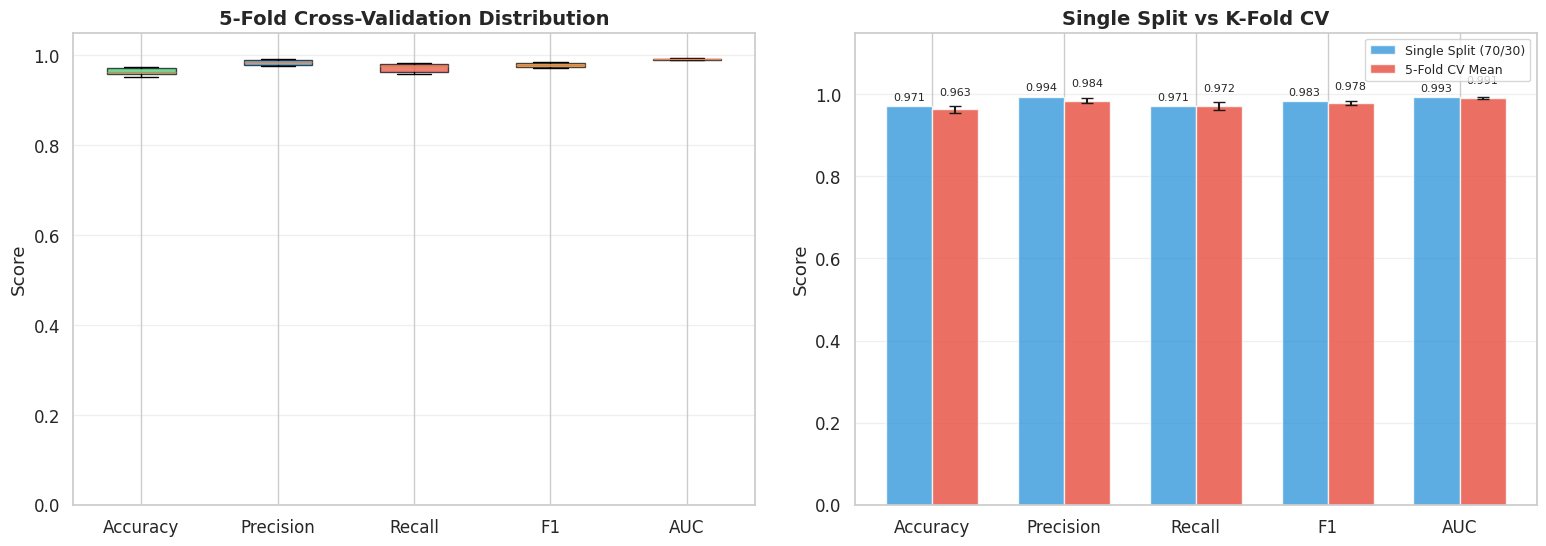


Đánh giá độ ổn định: 🟢 RẤT ỔN ĐỊNH
  Coefficient of Variation (F1): 0.51%
  → Model cho kết quả cực kỳ nhất quán qua các fold. Metric đáng tin cậy.


In [ ]:
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns

K = 5  # Số folds
print('=' * 60)
print(f'🔄 STRATIFIED {K}-FOLD CROSS-VALIDATION')
print('=' * 60)
print(f'Sử dụng toàn bộ dữ liệu (trước SMOTE): {len(y)} samples')
print(f'Features: PCA ({X.shape[1]} raw → PCA) + DDoSBert embeddings')
print()

# ── 1. Chuẩn bị dữ liệu GỐC (trước SMOTE, trước scale) ────
# Dùng X, y ban đầu (toàn bộ dataset sau clean) để k-fold
# Mỗi fold sẽ tự scale + SMOTE + PCA + fuse riêng → KHÔNG leakage

skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=RANDOM_SEED)

fold_metrics = {
    'accuracy': [], 'precision': [], 'recall': [],
    'f1': [], 'auc': [], 'fpr': []
}

for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f'── Fold {fold_idx + 1}/{K} ──')

    X_fold_train, X_fold_val = X[train_idx], X[val_idx]
    y_fold_train, y_fold_val = y[train_idx], y[val_idx]

    # 1. Scale (fit trên train fold)
    fold_scaler = StandardScaler()
    X_fold_train_sc = fold_scaler.fit_transform(X_fold_train)
    X_fold_val_sc = fold_scaler.transform(X_fold_val)

    # 2. SMOTE trên train fold
    fold_smote = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=RANDOM_SEED)
    X_fold_train_sm, y_fold_train_sm = fold_smote.fit_resample(X_fold_train_sc, y_fold_train)

    # 3. PCA (fit trên train fold sau SMOTE)
    fold_pca = PCA(n_components=0.95, svd_solver='full')
    X_fold_train_pca = fold_pca.fit_transform(X_fold_train_sm)
    X_fold_val_pca = fold_pca.transform(X_fold_val_sc)

    # 4. DDoSBert embeddings
    print(f'  Extracting embeddings (train: {len(X_fold_train_sm)}, val: {len(X_fold_val)})...')
    X_fold_train_emb, _ = extract_embeddings(X_fold_train_sm, scaler_obj=fold_scaler)
    X_fold_val_emb, _ = extract_embeddings(X_fold_val_sc, scaler_obj=fold_scaler)

    # 5. Fusion + LogisticRegression
    fold_model = HybridModelWithTiming(X_fold_train_pca.shape[1], X_fold_train_emb.shape[1])
    fold_model.train(X_fold_train_pca, X_fold_train_emb, y_fold_train_sm)

    # 6. Evaluate trên val fold (dữ liệu ORIGINAL, không SMOTE)
    fold_result = fold_model.evaluate(X_fold_val_pca, X_fold_val_emb, y_fold_val)

    for key in fold_metrics:
        fold_metrics[key].append(fold_result[key])

    print(f'  Acc={fold_result["accuracy"]:.4f}  '
          f'P={fold_result["precision"]:.4f}  '
          f'R={fold_result["recall"]:.4f}  '
          f'F1={fold_result["f1"]:.4f}  '
          f'AUC={fold_result["auc"]:.4f}  '
          f'FPR={fold_result["fpr"]:.4f}')
    print()

# ── 2. Tổng kết ────────────────────────────────────────────
print('=' * 60)
print(f'📊 {K}-FOLD CROSS-VALIDATION SUMMARY')
print('=' * 60)

summary_data = {}
for key in fold_metrics:
    vals = fold_metrics[key]
    mean_val = np.mean(vals)
    std_val = np.std(vals)
    summary_data[key] = {'mean': mean_val, 'std': std_val, 'values': vals}
    print(f'  {key.upper():>10s}: {mean_val:.4f} ± {std_val:.4f}  '
          f'(min={min(vals):.4f}, max={max(vals):.4f})')

# ── 3. Biểu đồ Box Plot ────────────────────────────────────
sns.set_theme(style='whitegrid', font_scale=1.1)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Box plot cho từng metric
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
metric_keys = ['accuracy', 'precision', 'recall', 'f1', 'auc']
colors = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12', '#9b59b6']

box_data = [fold_metrics[k] for k in metric_keys]
bp = axes[0].boxplot(box_data, patch_artist=True, labels=metric_names, widths=0.5)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[0].set_title(f'{K}-Fold Cross-Validation Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Score')
axes[0].set_ylim(0, 1.05)
axes[0].grid(axis='y', alpha=0.3)

# So sánh Mean CV vs Single Split
single_split_vals = [
    metrics['accuracy'], metrics['precision'], metrics['recall'],
    metrics['f1'], metrics['auc']
]
cv_mean_vals = [summary_data[k]['mean'] for k in metric_keys]
cv_std_vals = [summary_data[k]['std'] for k in metric_keys]

x = np.arange(len(metric_names))
width = 0.35

bars1 = axes[1].bar(x - width/2, single_split_vals, width,
                     label='Single Split (70/30)', color='#3498db', alpha=0.8)
bars2 = axes[1].bar(x + width/2, cv_mean_vals, width,
                     label=f'{K}-Fold CV Mean', color='#e74c3c', alpha=0.8,
                     yerr=cv_std_vals, capsize=4)

axes[1].set_title('Single Split vs K-Fold CV', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Score')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metric_names)
axes[1].set_ylim(0, 1.15)
axes[1].legend(loc='upper right', fontsize=9)
axes[1].grid(axis='y', alpha=0.3)

# Ghi giá trị lên cột
for bar in bars1:
    h = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, h + 0.01,
                 f'{h:.3f}', ha='center', va='bottom', fontsize=8)
for bar in bars2:
    h = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, h + 0.03,
                 f'{h:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout(pad=2.0)
plt.show()

# ── 4. Nhận xét tự động ────────────────────────────────────
print()
f1_std = summary_data['f1']['std']
f1_mean = summary_data['f1']['mean']
coeff_var = f1_std / f1_mean * 100

if coeff_var < 2:
    stability = '🟢 RẤT ỔN ĐỊNH'
    comment = 'Model cho kết quả cực kỳ nhất quán qua các fold. Metric đáng tin cậy.'
elif coeff_var < 5:
    stability = '🟡 ỔN ĐỊNH'
    comment = 'Model khá nhất quán. Kết quả đáng tin cậy.'
elif coeff_var < 10:
    stability = '🟠 CHẤP NHẬN ĐƯỢC'
    comment = 'Có biến thiên nhẹ giữa các fold, nhưng vẫn trong mức chấp nhận.'
else:
    stability = '🔴 KHÔNG ỔN ĐỊNH'
    comment = 'Biến thiên cao giữa các fold! Model có thể đang overfit hoặc data không đồng nhất.'

print(f'Đánh giá độ ổn định: {stability}')
print(f'  Coefficient of Variation (F1): {coeff_var:.2f}%')
print(f'  → {comment}')

## 7️⃣ Save Results

In [ ]:
results = {
    'methodology': 'Best Practice (Split First, SMOTE Train Only)',
    'dataset': {
        'total_samples': len(df),
        'train_original': len(y_train_raw),
        'train_after_smote': len(y_train),
        'test_original': len(y_test)
    },
    'metrics': {
        'accuracy': float(metrics['accuracy']),
        'precision': float(metrics['precision']),
        'recall': float(metrics['recall']),
        'f1': float(metrics['f1']),
        'auc': float(metrics['auc']),
        'fpr': float(metrics['fpr'])
    },
    'confusion_matrix': metrics['confusion_matrix'],
    'complexity': {
        'train_embedding_time_sec': train_emb_time,
        'test_embedding_time_sec': test_emb_time,
        'training_time_sec': metrics['timing']['train_time'],
        'inference_time_sec': metrics['timing']['inference_time'],
        'inference_per_sample_ms': metrics['timing']['inference_per_sample'],
        'throughput_samples_per_sec': len(y_test) / metrics['timing']['inference_time']
    },
    'model_info': {
        'pca_components': int(pca.n_components_),
        'embedding_dim': X_train_emb.shape[1],
        'fusion_method': 'attention'
    }
}

with open('hybrid_results_paper.json', 'w') as f:
    json.dump(results, f, indent=2)

print("Results saved to hybrid_results_paper.json")
files.download('hybrid_results_paper.json')

Results saved to hybrid_results_paper.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

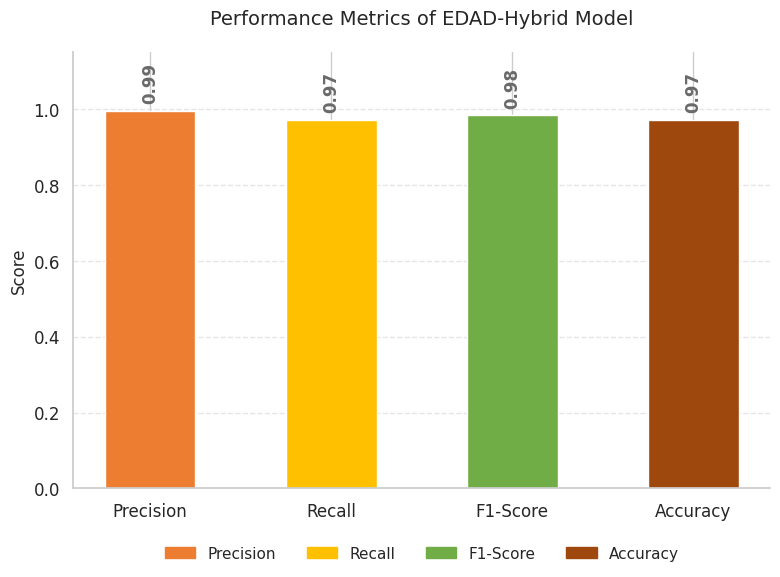

Đã lưu biểu đồ thành file 'performance_chart.png'. Bạn có thể tải về.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Dữ liệu (Dựa trên kết quả Hybrid Model của bạn)
metrics_list = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
values = [
    results['metrics']['precision'],
    results['metrics']['recall'],
    results['metrics']['f1'],
    results['metrics']['accuracy']
]

# 2. Cấu hình màu sắc (Giống hệt hình mẫu bạn gửi)
# Cam, Vàng, Xanh lá, Nâu đỏ
colors = ['#ED7D31', '#FFC000', '#70AD47', '#9E480E']

# 3. Tạo biểu đồ
fig, ax = plt.subplots(figsize=(8, 6))

# Vẽ các cột
bars = ax.bar(metrics_list, values, color=colors, width=0.5)

# 4. Thêm số liệu nằm dọc trên đầu cột (Giống hình mẫu)
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2., # Vị trí X (giữa cột)
        height + 0.02,                      # Vị trí Y (cao hơn cột một chút)
        f'{height:.2f}',                    # Định dạng số (2 chữ số thập phân)
        ha='center', va='bottom',           # Căn lề
        rotation=90,                        # Xoay dọc 90 độ
        fontsize=12, fontweight='bold', color='dimgrey'
    )

# 5. Trang trí biểu đồ cho chuẩn bài báo khoa học
ax.set_ylim(0, 1.15)  # Mở rộng trục Y để chứa được chữ số xoay dọc
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Performance Metrics of Hybrid Model', fontsize=14, pad=20)

# Xóa khung viền trên và phải cho thoáng (Giống phong cách hiện đại)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Thêm lưới mờ trục Y để dễ nhìn
ax.grid(axis='y', linestyle='--', alpha=0.5)

# Tạo Legend (Chú thích) giống hình mẫu
# Vì mỗi cột 1 màu nên ta tạo legend thủ công để khớp màu
handles = [plt.Rectangle((0,0),1,1, color=c) for c in colors]
plt.legend(handles, metrics_list, loc='upper center', bbox_to_anchor=(0.5, -0.1),
           ncol=4, frameon=False, fontsize=11)

plt.tight_layout()

# Lưu ảnh để tải về
plt.savefig('performance_chart.png', dpi=300, bbox_inches='tight')
plt.show()

print("Đã lưu biểu đồ thành file 'performance_chart.png'. Bạn có thể tải về.")

Computing t-SNE for Tabular data...
Computing t-SNE for Hybrid data...


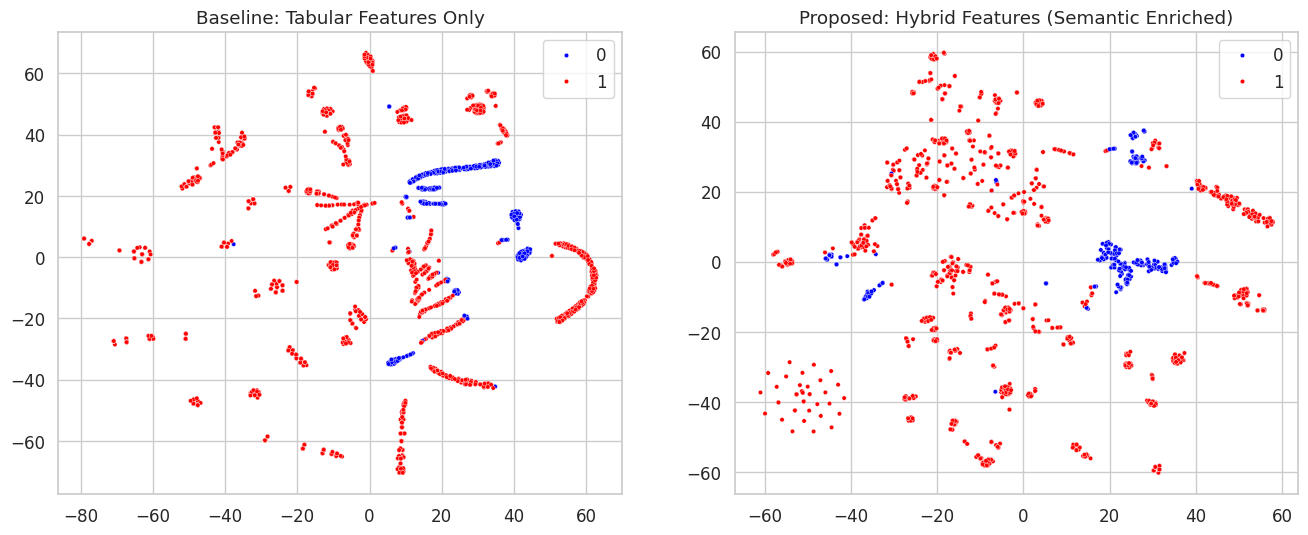

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

def plot_tsne_comparison(X_pca, X_emb, y, num_samples=2000):
    # Lấy mẫu ngẫu nhiên để vẽ
    rng = np.random.RandomState(RANDOM_SEED)
    indices = rng.choice(len(X_pca), num_samples, replace=False)
    X_pca_sub = X_pca[indices]
    X_emb_sub = X_emb[indices]
    y_sub = y[indices]

    # 1. t-SNE cho Tabular (Baseline)
    print("Computing t-SNE for Tabular data...")
    tsne_tab = TSNE(n_components=2, random_state=42).fit_transform(X_pca_sub)

    # 2. t-SNE cho Hybrid (Tabular + Embedding)
    print("Computing t-SNE for Hybrid data...")
    # Nối 2 loại đặc trưng lại để vẽ
    X_hybrid = np.hstack((X_pca_sub, X_emb_sub))
    tsne_hyb = TSNE(n_components=2, random_state=42).fit_transform(X_hybrid)

    # Vẽ hình
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: Tabular Only
    sns.scatterplot(x=tsne_tab[:,0], y=tsne_tab[:,1], hue=y_sub, palette=['blue', 'red'], ax=axes[0], s=10)
    axes[0].set_title('Baseline: Tabular Features Only')

    # Plot 2: Hybrid
    sns.scatterplot(x=tsne_hyb[:,0], y=tsne_hyb[:,1], hue=y_sub, palette=['blue', 'red'], ax=axes[1], s=10)
    axes[1].set_title('Proposed: Hybrid Features (Semantic Enriched)')

    plt.show()

plot_tsne_comparison(X_test_pca, X_test_emb, y_test)

In [ ]:
import time

def measure_latency(model, X_pca_sample, X_emb_sample, num_samples=1000):
    start_time = time.time()
    # Chạy dự đoán trên 1000 mẫu
    _ = model.classifier.predict(model.fuse(X_pca_sample[:num_samples],
                                                     X_emb_sample[:num_samples]))
    total_time = time.time() - start_time
    avg_time_per_flow = (total_time / num_samples) * 1000 # Đổi sang ms

    print(f"Inference Latency Analysis:")
    print(f"   - Total time for {num_samples} flows: {total_time:.4f}s")
    print(f"   - Average time per flow: {avg_time_per_flow:.4f} ms")

# Gọi hàm
measure_latency(model, X_test_pca, X_test_emb)

Inference Latency Analysis:
   - Total time for 1000 flows: 0.0036s
   - Average time per flow: 0.0036 ms
